In [1]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

import tensorflow as tf
from keras import layers, models
import numpy as np
import datetime
#import capsnet
from SegCaps import capsule_layers
import dataset
import model_functions as mf
import audio_functions as af
import audio_models

import IPython.display as ipd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['image.cmap'] = 'hot'


Using TensorFlow backend.


In [5]:
#  Set variables
sample_rate=16384
n_fft=1024
fft_hop=256
patch_window=256
patch_hop=128
n_parallel_readers=16
normalise=True
batch_size = 1
shuffle=False
n_shuffle = 1
mag_phase = True
learning_rate = 0.0002
model_variant = 'basic_capsnet'
data_type = 'mag'
phase_weight = 0.0005

checkpoint = '266/266-8'
model_base_dir = '/home/enterprise.internal.city.ac.uk/acvn728/checkpoints'

directory_a = '/home/enterprise.internal.city.ac.uk/acvn728/miniCHiME/Mixed'
directory_b = '/home/enterprise.internal.city.ac.uk/acvn728/miniCHiME/Voice'
directory_c = '/home/enterprise.internal.city.ac.uk/acvn728/miniCHiME/Background'

#directory_a = 'C:/Users/Toby/MSc_Project/Test_Audio/miniCHiME/Mixed'
#directory_b = 'C:/Users/Toby/MSc_Project/Test_Audio/miniCHiME/Voice'
#directory_c = 'C:/Users/Toby/MSc_Project/Test_Audio/miniCHiME/Background'


#  Create the pipeline
tf.reset_default_graph()
data = dataset.zip_files(directory_a, directory_b, directory_c)
data = dataset.get_paired_dataset(data,
                                  sample_rate,
                                  n_fft,
                                  fft_hop,
                                  patch_window,
                                  patch_hop,
                                  n_parallel_readers,
                                  batch_size,
                                  n_shuffle,
                                  normalise)

#  Create the iterator
pipe = data.make_initializable_iterator()
mixed_spec, voice_spec, background_spec, mixed_audio, voice_audio, background_audio = pipe.get_next()

#  Create variable placeholders
is_training = tf.placeholder(shape=(), dtype=bool)
mixed_phase = tf.expand_dims(mixed_spec[:, :, :-1, 3], 3)
if data_type == 'mag':
    mixed_input = tf.expand_dims(mixed_spec[:, :, :-1, 2], 3)
    voice_input = tf.expand_dims(voice_spec[:, :, :-1, 2], 3)
elif data_type in ['mag_phase', 'mag_phase_diff']:
    mixed_input = mixed_spec[:, :, :-1, 2:4]
    voice_input = voice_spec[:, :, :-1, 2:4]
elif data_type == 'real_imag':
    mixed_input = mixed_spec[:, :, :-1, 0:2]
    voice_input = voice_spec[:, :, :-1, 0:2]
elif data_type == 'mag_real_imag':
    mixed_input = tf.concat([tf.expand_dims(mixed_spec[:, :, :-1, 2], 3), mixed_spec[:, :, :-1, 0:2]], 3)
    voice_input = tf.concat([tf.expand_dims(voice_spec[:, :, :-1, 2], 3), voice_spec[:, :, :-1, 0:2]], 3)
elif data_type == 'mag_phase_real_imag':
    mixed_input = mixed_spec[:, :, :-1, :]
    voice_input = voice_spec[:, :, :-1, :]
    
data

<PrefetchDataset shapes: ((?, 256, 513, 4), (?, 256, 513, 4), (?, 256, 513, 4), (?, 65280, 1), (?, 65280, 1), (?, 65280, 1)), types: (tf.float32, tf.float32, tf.float32, tf.float32, tf.float32, tf.float32)>

In [6]:
# Build U-Net model
print('Creating model')
model = audio_models.MagnitudeModel(mixed_input, voice_input, mixed_phase, mixed_audio, 
                                    voice_audio, background_audio, model_variant, is_training, learning_rate, 
                                    data_type, phase_weight, name='Magnitude_Model')
tf_config = tf.ConfigProto()
tf_config.gpu_options.allow_growth = True
tf_config.gpu_options.visible_device_list = str(1)
sess = tf.Session(config=tf_config)
sess.run(tf.global_variables_initializer())

Creating model


In [7]:

print('Loading checkpoint')
checkpoint_path = os.path.join(model_base_dir, checkpoint)
restorer = tf.train.Saver()
restorer.restore(sess, checkpoint_path)

Loading checkpoint
INFO:tensorflow:Restoring parameters from /home/enterprise.internal.city.ac.uk/acvn728/checkpoints/266/266-8


In [8]:
# Get Intermediate values from Capsunet
try:
    mix, voice, mask, gen_voice, conv,\
       pc, cc2, cc3, out = sess.run([model.mixed_input, model.voice_input, model.voice_mask, model.gen_voice, 
                                     model.voice_mask_network.encoder.conv1, model.voice_mask_network.encoder.primary_caps, 
                                     model.voice_mask_network.encoder.conv_cap_2, model.voice_mask_network.encoder.conv_cap_3,
                                     model.voice_mask_network.encoder.output])
except tf.errors.OutOfRangeError:
    sess.run(pipe.initializer)

AttributeError: 'MagnitudeModel' object has no attribute 'mixed_mag'

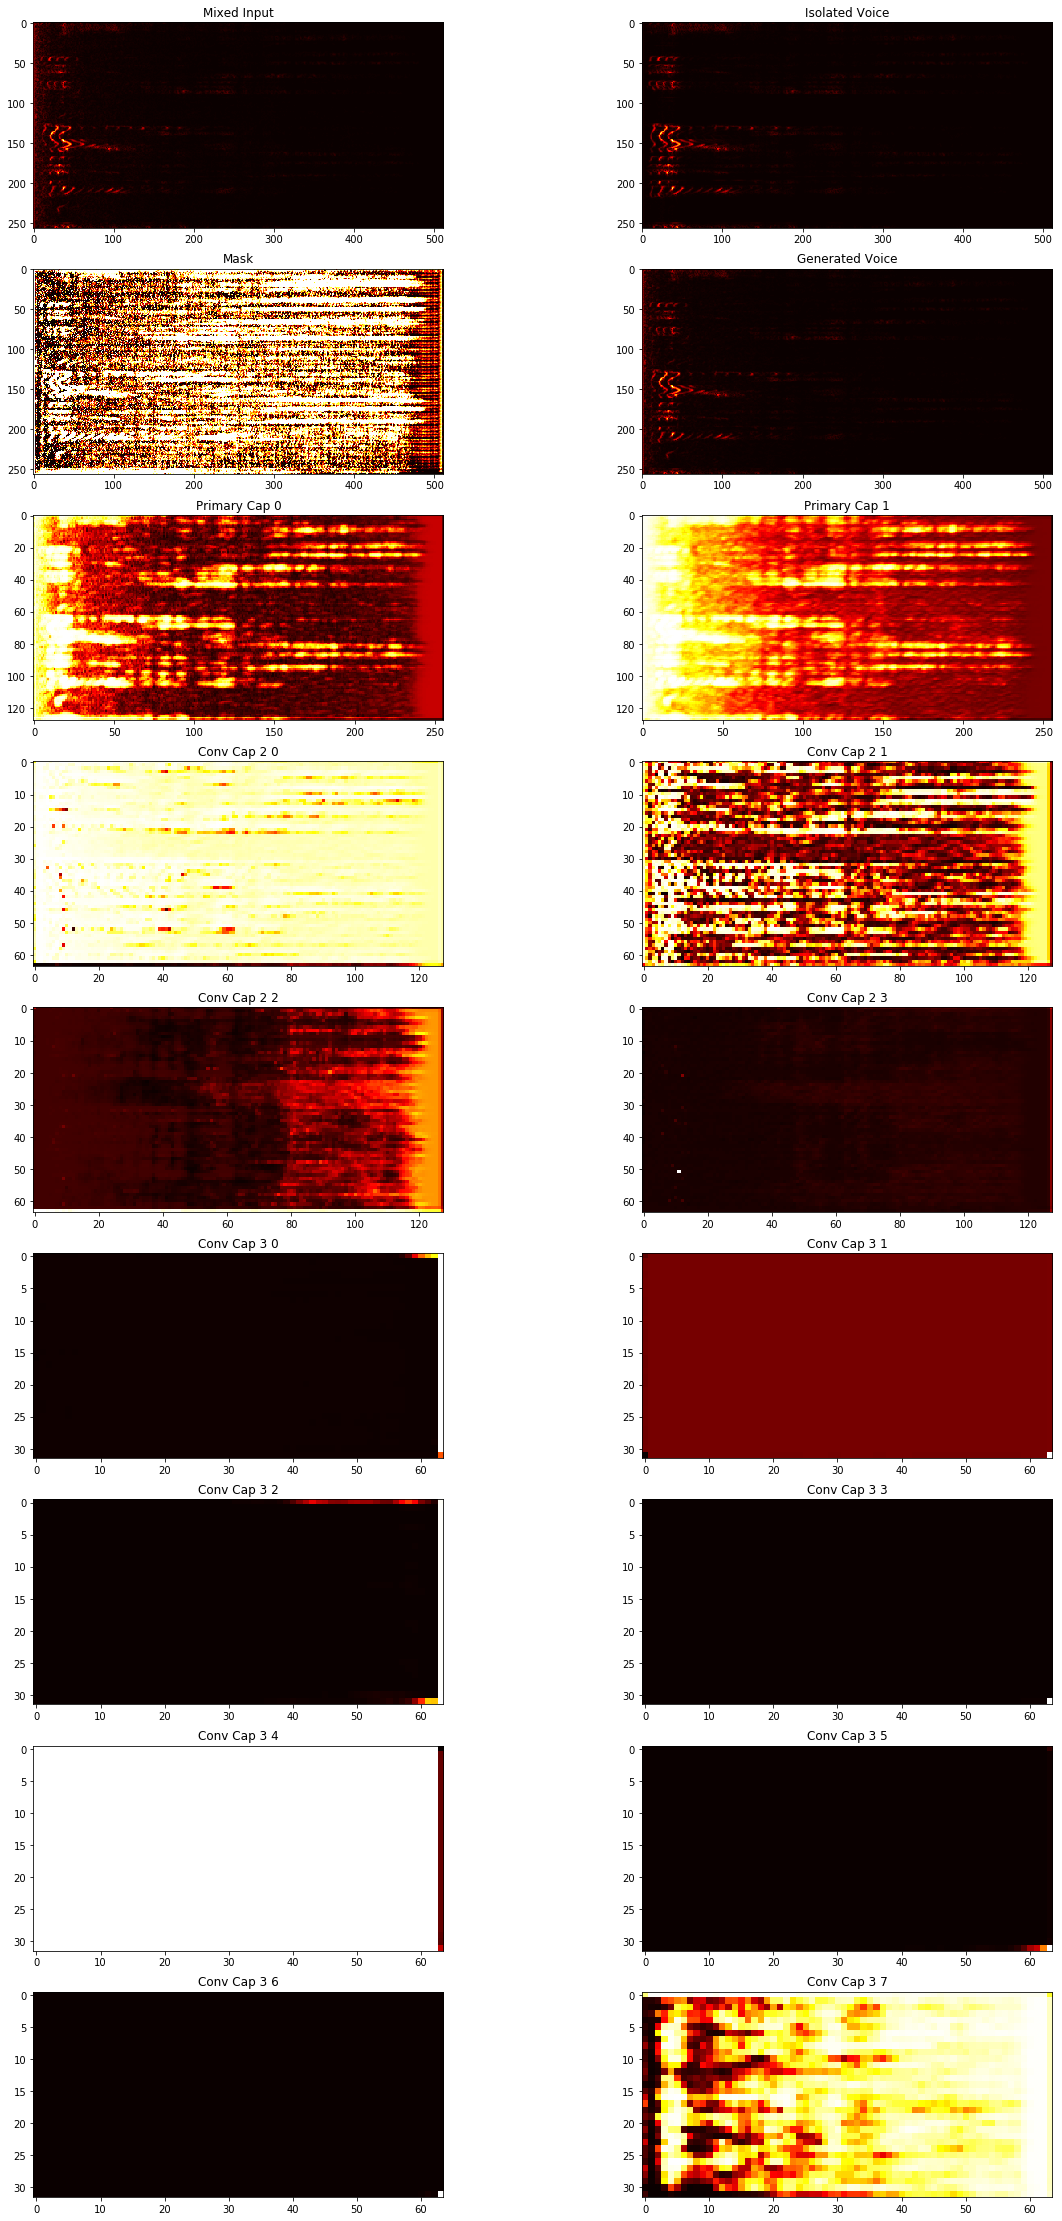

In [41]:
# Plot values
fig, ax = plt.subplots(9,2, figsize=(20,40))
#fig.suptitle('Caps-U-Net Intermediate Activations')
i = 0
ax[0,0].imshow(mix[i,:,:,0])
ax[0,0].set_title('Mixed Input')
ax[0,1].imshow(voice[i,:,:,0])
ax[0,1].set_title('Isolated Voice')
ax[1,0].imshow(mask[i,:,:,0])
ax[1,0].set_title('Mask')
ax[1,1].imshow(gen_voice[i,:,:,0])
ax[1,1].set_title('Generated Voice')
ax[2,0].imshow(np.linalg.norm(pc, axis=4)[i, :, :, 0])
ax[2,0].set_title('Primary Cap 0')
ax[2,1].imshow(np.linalg.norm(pc, axis=4)[i, :, :, 1])
ax[2,1].set_title('Primary Cap 1')
ax[3,0].imshow(np.linalg.norm(cc2, axis=4)[i, :, :, 0])
ax[3,0].set_title('Conv Cap 2 0')
ax[3,1].imshow(np.linalg.norm(cc2, axis=4)[i, :, :, 1])
ax[3,1].set_title('Conv Cap 2 1')
ax[4,0].imshow(np.linalg.norm(cc2, axis=4)[i, :, :, 2])
ax[4,0].set_title('Conv Cap 2 2')
ax[4,1].imshow(np.linalg.norm(cc2, axis=4)[i, :, :, 3])
ax[4,1].set_title('Conv Cap 2 3')
ax[5,0].imshow(np.linalg.norm(cc3, axis=4)[i, :, :, 0])
ax[5,0].set_title('Conv Cap 3 0')
ax[5,1].imshow(np.linalg.norm(cc3, axis=4)[i, :, :, 1])
ax[5,1].set_title('Conv Cap 3 1')
ax[6,0].imshow(np.linalg.norm(cc3, axis=4)[i, :, :, 2])
ax[6,0].set_title('Conv Cap 3 2')
ax[6,1].imshow(np.linalg.norm(cc3, axis=4)[i, :, :, 3])
ax[6,1].set_title('Conv Cap 3 3')
ax[7,0].imshow(np.linalg.norm(cc3, axis=4)[i, :, :, 4])
ax[7,0].set_title('Conv Cap 3 4')
ax[7,1].imshow(np.linalg.norm(cc3, axis=4)[i, :, :, 5])
ax[7,1].set_title('Conv Cap 3 5')
ax[8,0].imshow(np.linalg.norm(cc3, axis=4)[i, :, :, 6])
ax[8,0].set_title('Conv Cap 3 6')
ax[8,1].imshow(np.linalg.norm(cc3, axis=4)[i, :, :, 7])
ax[8,1].set_title('Conv Cap 3 7')
#plt.tight_layout()
plt.show()
fig.savefig('Figures/Capsunet_vis.png')

In [12]:
# Get intermediate values form basic capsnet
sess.run(pipe.initializer)
try:
    mix, voice, mask, gen_voice, conv,\
       pc, seg = sess.run([model.mixed_input, model.voice_input, model.voice_mask, model.gen_voice, model.voice_mask_network.conv1,
                           model.voice_mask_network.primary_caps, model.voice_mask_network.seg_caps])
except tf.errors.OutOfRangeError:
    sess.run(pipe.initializer)
    print('End of Dataset')

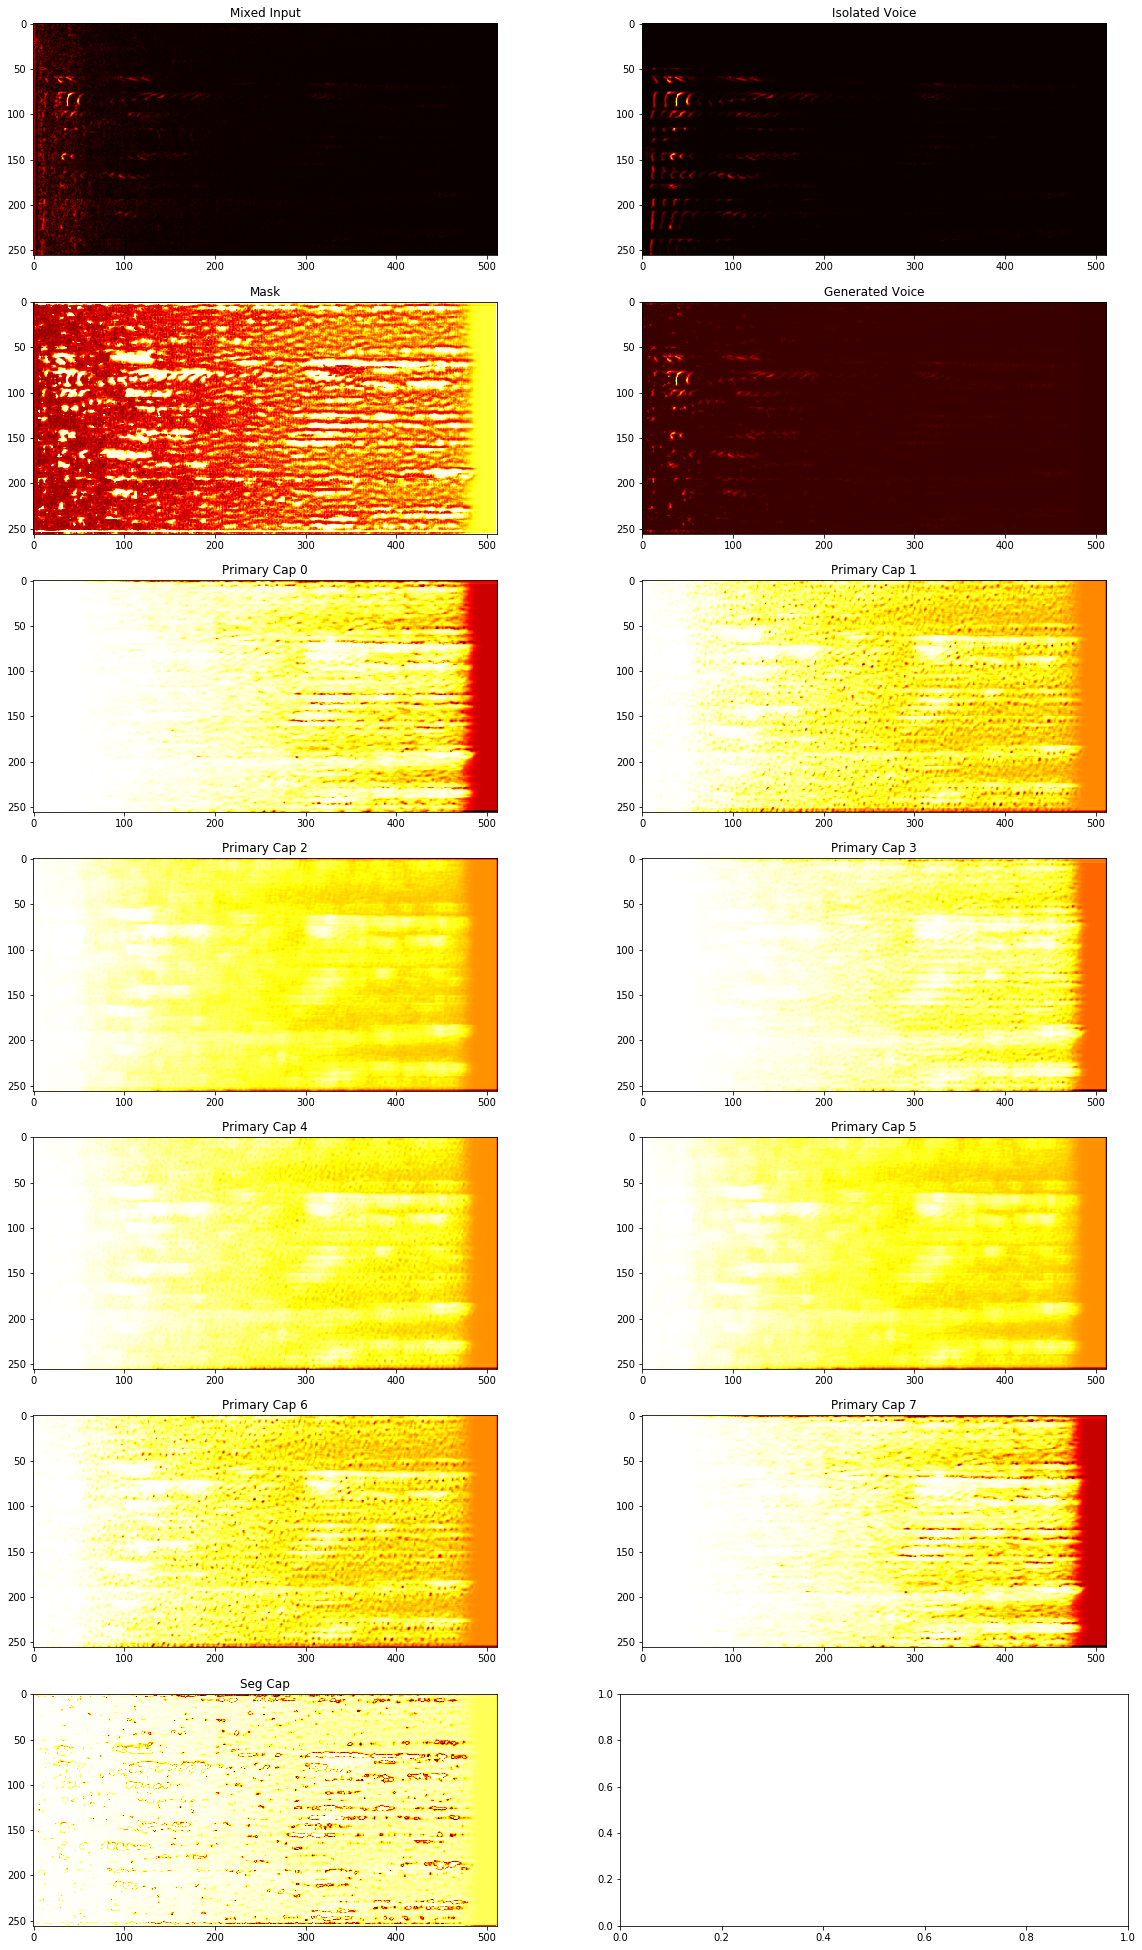

In [13]:
# Plot Values
fig, ax = plt.subplots(7,2, figsize=(20,35))
#fig.suptitle('Basic Capsnet Activations')
i=0

ax[0,0].imshow(mix[i,:,:,0])
ax[0,0].set_title('Mixed Input')
ax[0,1].imshow(voice[i,:,:,0])
ax[0,1].set_title('Isolated Voice')
ax[1,0].imshow(mask[i,:,:,0])
ax[1,0].set_title('Mask')
ax[1,1].imshow(gen_voice[i,:,:,0])
ax[1,1].set_title('Generated Voice')
ax[2,0].imshow(np.linalg.norm(pc, axis=4)[i, :, :, 0])
ax[2,0].set_title('Primary Cap 0')
ax[2,1].imshow(np.linalg.norm(pc, axis=4)[i, :, :, 1])
ax[2,1].set_title('Primary Cap 1')
ax[3,0].imshow(np.linalg.norm(pc, axis=4)[i, :, :, 2])
ax[3,0].set_title('Primary Cap 2')
ax[3,1].imshow(np.linalg.norm(pc, axis=4)[i, :, :, 3])
ax[3,1].set_title('Primary Cap 3')
ax[4,0].imshow(np.linalg.norm(pc, axis=4)[i, :, :, 4])
ax[4,0].set_title('Primary Cap 4')
ax[4,1].imshow(np.linalg.norm(pc, axis=4)[i, :, :, 5])
ax[4,1].set_title('Primary Cap 5')
ax[5,0].imshow(np.linalg.norm(pc, axis=4)[i, :, :, 6])
ax[5,0].set_title('Primary Cap 6')
ax[5,1].imshow(np.linalg.norm(pc, axis=4)[i, :, :, 7])
ax[5,1].set_title('Primary Cap 7')
ax[6,0].imshow(np.linalg.norm(seg, axis=4)[i, :, :, 0])
ax[6,0].set_title('Seg Cap')
fig.savefig('Figures/Basic_capsnet_vis.png')

In [9]:
tf.trainable_variables()

[<tf.Variable 'Magnitude_Model/basic_capsnet/layer_1/conv2d/kernel:0' shape=(5, 5, 1, 128) dtype=float32_ref>,
 <tf.Variable 'Magnitude_Model/basic_capsnet/layer_1/conv2d/bias:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'Magnitude_Model/basic_capsnet/layer_2/W:0' shape=(5, 5, 128, 128) dtype=float32_ref>,
 <tf.Variable 'Magnitude_Model/basic_capsnet/layer_2/b:0' shape=(1, 1, 8, 16) dtype=float32_ref>,
 <tf.Variable 'Magnitude_Model/basic_capsnet/layer_3/W:0' shape=(1, 1, 16, 16) dtype=float32_ref>,
 <tf.Variable 'Magnitude_Model/basic_capsnet/layer_3/b:0' shape=(1, 1, 1, 16) dtype=float32_ref>,
 <tf.Variable 'Magnitude_Model/basic_capsnet/mask/W:0' shape=(1, 1, 16, 1) dtype=float32_ref>,
 <tf.Variable 'Magnitude_Model/basic_capsnet/mask/b:0' shape=(1, 1, 1, 1) dtype=float32_ref>]

In [74]:
print(conv.shape)
print(pc.shape)
print(cc2.shape)
print(cc3.shape)

(5, 256, 512, 16)
(5, 128, 256, 2, 8)
(5, 64, 128, 4, 8)
(5, 32, 64, 8, 16)


In [72]:
# Take a single capsule type from layer conv caps 2, for a single data item
cc2_cap0_item0 = np.squeeze(cc2[0,:,:,0,:])
cc2_cap0_item0.shape

(64, 128, 8)

In [73]:
# Get the weights that wil be applied to it in the next layer
cc3_w = sess.run('Magnitude_Model/voice-mask-unet/Encoder/conv_cap_3/W:0')
print(cc3_w.shape)
cc3_w_reshaped = np.reshape(cc3_w, (5, 5, 8, 8, 16))
cc3_w_reshaped.shape

(5, 5, 8, 128)


(5, 5, 8, 8, 16)

In [39]:
cc3_reshaped[:,:,:,0,:]

array([[[[ 0.02687081, -0.09661791, -0.1343285 , ..., -0.2712202 ,
          -0.11736767, -0.30885553],
         [ 0.05238133, -0.15715344,  0.2571148 , ..., -0.14327812,
          -0.210067  ,  0.22829056],
         [ 0.22777891, -0.14055741, -0.09071767, ...,  0.01933592,
          -0.06787935, -0.10842403],
         ...,
         [-0.04573121, -0.08826085,  0.31981364, ...,  0.02852294,
          -0.13504821,  0.05321596],
         [-0.28634065,  0.1020247 ,  0.19019705, ..., -0.0495974 ,
           0.00200163,  0.11025967],
         [-0.11505876,  0.02016716,  0.0006809 , ...,  0.25517046,
           0.25478   , -0.08701903]],

        [[ 0.36598516,  0.18456794, -0.14566304, ..., -0.30583486,
           0.04298907,  0.28715262],
         [ 0.01011287, -0.17260095, -0.05371707, ..., -0.33295777,
           0.14485267,  0.23646201],
         [-0.06791302, -0.05375712, -0.0480696 , ...,  0.0904144 ,
           0.19459365,  0.02891793],
         ...,
         [ 0.14368364, -0.39914173

In [40]:
cc3_reshaped[:,:,:,1,:]

array([[[[ 6.31426126e-02,  1.37174994e-01, -3.84709954e-01, ...,
           3.52262646e-01,  5.88652380e-02,  5.89126170e-01],
         [ 2.53855884e-01, -7.53096789e-02, -2.10023642e-01, ...,
          -2.06432074e-01, -4.74784791e-01, -1.00104235e-01],
         [ 2.59973764e-01, -6.67779297e-02,  2.52606004e-01, ...,
           8.70798901e-02, -2.97951102e-01, -8.13242197e-02],
         ...,
         [-2.33863071e-01,  1.82152361e-01, -7.08098114e-02, ...,
           8.08891952e-02, -4.06792052e-02, -9.64482967e-03],
         [-1.77198976e-01, -3.72684479e-01, -8.61612186e-02, ...,
          -2.73910135e-01, -6.73823655e-01, -1.19362779e-01],
         [ 9.39403549e-02, -1.03608221e-01, -2.40869150e-01, ...,
           1.94318831e-01, -9.76621136e-02,  8.91322643e-02]],

        [[-1.37407660e-01,  3.16599369e-01, -1.40270621e-01, ...,
           6.16109446e-02,  2.44353097e-02,  1.04322009e-01],
         [-1.61562681e-01, -1.10864624e-01, -8.69257227e-02, ...,
          -1.63906932e